somewhat works, but still has positional issues 2025-08-04


In [36]:
# Import necessary libraries
import os
import json
import base64
from typing import Dict, List, Tuple, Optional
import pymupdf as fitz
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import requests
from io import BytesIO

# For Google Gemini
try:
    import google.generativeai as genai
    GEMINI_AVAILABLE = True
except ImportError:
    GEMINI_AVAILABLE = False
    print("Google Gemini not available. Install with: pip install google-generativeai")

# For Groq
try:
    from groq import Groq
    GROQ_AVAILABLE = True
except ImportError:
    GROQ_AVAILABLE = False
    print("Groq not available. Install with: pip install groq")

print(f"Gemini available: {GEMINI_AVAILABLE}")
print(f"Groq available: {GROQ_AVAILABLE}")


Gemini available: True
Groq available: True


In [45]:
# Configuration
from dotenv import load_dotenv
import pathlib

# Load .env file from the project root (relative to this notebook)
env_path = pathlib.Path().resolve().parent.parent.parent / '.env'
load_dotenv(dotenv_path=env_path)

USE_GEMINI = True  # Set to False to use Groq instead

GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
GROQ_API_KEY = os.getenv('GROQ_API_KEY')
google_model_options = ['gemma-3-27b-it','gemini-2.5-flash','gemini-2.5-pro']
# Configure the chosen LLM
if USE_GEMINI and GEMINI_AVAILABLE:
    genai.configure(api_key=GEMINI_API_KEY)
    model = genai.GenerativeModel('gemini-2.5-flash')
    print("Using Google Gemini")
elif GROQ_AVAILABLE:
    groq_client = Groq(api_key=GROQ_API_KEY)
    print("Using Groq")
else:
    print("No LLM service available. Please install the required packages.")

print("Last 5 characters of Gemini key:", GEMINI_API_KEY[-5:] if GEMINI_API_KEY else None)



Using Google Gemini
Last 5 characters of Gemini key: L1eyw


In [38]:
def pdf_to_image(pdf_path: str, page_num: int = 0, dpi: int = 150) -> Tuple[Image.Image, Dict]:
    """
    Convert a PDF page to an image and return both the image and page dimensions.
    
    Args:
        pdf_path: Path to the PDF file
        page_num: Page number to convert (0-indexed)
        dpi: DPI for the image conversion
    
    Returns:
        Tuple of (PIL Image, page_info dict with dimensions)
    """
    doc = fitz.open(pdf_path)
    page = doc[page_num]
    
    # Get page dimensions in points (1 point = 1/72 inch)
    page_rect = page.rect
    page_info = {
        'width_points': page_rect.width,
        'height_points': page_rect.height,
        'width_pixels': None,
        'height_pixels': None,
        'dpi': dpi
    }
    
    # Convert to image
    mat = fitz.Matrix(dpi/72, dpi/72)  # Scale factor for DPI
    pix = page.get_pixmap(matrix=mat)
    img_data = pix.tobytes("png")
    img = Image.open(BytesIO(img_data))
    
    # Update pixel dimensions
    page_info['width_pixels'] = img.width
    page_info['height_pixels'] = img.height
    
    doc.close()
    return img, page_info

def image_to_base64(image: Image.Image) -> str:
    """Convert PIL Image to base64 string for API calls."""
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    return img_str


In [39]:
def upload_pdf_to_gemini(pdf_path: str):
    """
    Upload PDF file to Gemini using Files API and return the file object.
    
    Args:
        pdf_path: Path to the PDF file
    
    Returns:
        File object for use with Gemini API
    """
    try:
        # Upload the file
        uploaded_file = genai.upload_file(path=pdf_path, display_name=os.path.basename(pdf_path))
        print(f"📤 Uploaded file: {uploaded_file.display_name}")
        print(f"📋 File URI: {uploaded_file.uri}")
        
        # Wait for the file to be processed
        import time
        while uploaded_file.state.name == "PROCESSING":
            print("⏳ Processing file...")
            time.sleep(2)
            uploaded_file = genai.get_file(uploaded_file.name)
        
        if uploaded_file.state.name == "FAILED":
            raise ValueError(f"File processing failed: {uploaded_file.state}")
            
        print("✅ File processed successfully")
        return uploaded_file
        
    except Exception as e:
        print(f"Error uploading PDF to Gemini: {e}")
        return None

def create_image_extraction_prompt(page_info: Dict) -> str:
    """
    Create a prompt for image analysis with pixel coordinate system information.
    
    Args:
        page_info: Dictionary containing page dimensions
    
    Returns:
        Formatted prompt string for image analysis
    """
    prompt = f"""
You are analyzing an electrical as-built drawing image. Please identify and locate ALL individual text elements with their bounding boxes. 
Create a separate bounding box for EACH unique instance of the element with its specific label.

Look for these types of elements:
1. **Inverter Block labels** - these will be labelled as "Block X.X" (e.g., "Block 1.1", "Block 1.2", "Block 2.1")
2. **Combiner block labels** - these will be labelled as "X.X.X.C.X" (e.g., "1.2.3.C.1", "1.2.3.C.2", "2.1.4.C.1")

**IMPORTANT COORDINATE SYSTEM:**
- The image dimensions are: {page_info['width_pixels']} x {page_info['height_pixels']} pixels
- Origin (0,0) is at the TOP-LEFT corner
- X coordinates increase going RIGHT
- Y coordinates increase going DOWN
- All coordinates should be in pixels relative to these dimensions

Respond with a JSON object containing arrays of elements for each type:

```json
{{
  "inverter_blocks": [
    {{
      "label": "Block 1.1",
      "bounding_box": {{
        "x": left_coordinate_in_pixels,
        "y": top_coordinate_in_pixels,
        "width": box_width_in_pixels,
        "height": box_height_in_pixels
      }},
      "confidence": 0.0-1.0
    }},
    {{
      "label": "Block 1.2", 
      "bounding_box": {{
        "x": left_coordinate_in_pixels,
        "y": top_coordinate_in_pixels,
        "width": box_width_in_pixels,
        "height": box_height_in_pixels
      }},
      "confidence": 0.0-1.0
    }}
  ],
  "combiner_blocks": [
    {{
      "label": "1.2.3.C.1",
      "bounding_box": {{
        "x": left_coordinate_in_pixels,
        "y": top_coordinate_in_pixels,
        "width": box_width_in_pixels,
        "height": box_height_in_pixels
      }},
      "confidence": 0.0-1.0
    }},
    {{
      "label": "1.2.3.C.2",
      "bounding_box": {{
        "x": left_coordinate_in_pixels,
        "y": top_coordinate_in_pixels,
        "width": box_width_in_pixels,
        "height": box_height_in_pixels
      }},
      "confidence": 0.0-1.0
    }}
  ]
}}
```

Requirements:
- Make sure all coordinates are within the image bounds (0 ≤ x ≤ {page_info['width_pixels']}, 0 ≤ y ≤ {page_info['height_pixels']})
- Include the exact label text found in the image (e.g., "Block 1.2", "1.2.3.C.1")
- If no elements of a type are found, return an empty array []
- Each bounding box should tightly fit around the text label
"""
    return prompt

def create_pdf_extraction_prompt(page_info: Dict) -> str:
    """
    Create a prompt for PDF analysis with proper coordinate system information.
    
    Args:
        page_info: Dictionary containing page dimensions
    
    Returns:
        Formatted prompt string for PDF analysis
    """
    prompt = f"""
You are analyzing an electrical as-built drawing PDF. Please identify and locate ALL individual text elements with their bounding boxes. 
Create a separate bounding box for EACH unique instance of the element with its specific label.

Look for these types of elements:
1. **Inverter Block labels** - these will be labelled as "Block X.X" (e.g., "Block 1.1", "Block 1.2", "Block 2.1")
2. **Combiner block labels** - these will be labelled as "X.X.X.C.X" (e.g., "1.2.3.C.1", "1.2.3.C.2", "2.1.4.C.1")

**IMPORTANT COORDINATE SYSTEM:**
- This is a PDF document with dimensions: {page_info['width_points']:.1f} x {page_info['height_points']:.1f} points
- Origin (0,0) is at the BOTTOM-LEFT corner (PDF standard)
- X coordinates increase going RIGHT
- Y coordinates increase going UP
- All coordinates should be in PDF points (1 point = 1/72 inch)

Respond with a JSON object containing arrays of elements for each type:

```json
{{
  "inverter_blocks": [
    {{
      "label": "Block 1.1",
      "bounding_box": {{
        "x": left_coordinate_in_points,
        "y": bottom_coordinate_in_points,
        "width": box_width_in_points,
        "height": box_height_in_points
      }},
      "confidence": 0.0-1.0
    }},
    {{
      "label": "Block 1.2", 
      "bounding_box": {{
        "x": left_coordinate_in_points,
        "y": bottom_coordinate_in_points,
        "width": box_width_in_points,
        "height": box_height_in_points
      }},
      "confidence": 0.0-1.0
    }}
  ],
  "combiner_blocks": [
    {{
      "label": "1.2.3.C.1",
      "bounding_box": {{
        "x": left_coordinate_in_points,
        "y": bottom_coordinate_in_points,
        "width": box_width_in_points,
        "height": box_height_in_points
      }},
      "confidence": 0.0-1.0
    }},
    {{
      "label": "1.2.3.C.2",
      "bounding_box": {{
        "x": left_coordinate_in_points,
        "y": bottom_coordinate_in_points,
        "width": box_width_in_points,
        "height": box_height_in_points
      }},
      "confidence": 0.0-1.0
    }}
  ]
}}
```

Requirements:
- Make sure all coordinates are within the PDF bounds (0 ≤ x ≤ {page_info['width_points']:.1f}, 0 ≤ y ≤ {page_info['height_points']:.1f})
- Include the exact label text found in the PDF (e.g., "Block 1.2", "1.2.3.C.1")
- If no elements of a type are found, return an empty array []
- Each bounding box should tightly fit around the text label
"""
    return prompt

def call_gemini_with_pdf(pdf_file, prompt: str) -> str:
    """
    Call Google Gemini API with uploaded PDF file and prompt.
    
    Args:
        pdf_file: Uploaded file object from Gemini Files API
        prompt: Text prompt for analysis
    
    Returns:
        LLM response text
    """
    try:
        response = model.generate_content([prompt, pdf_file])
        return response.text
    except Exception as e:
        print(f"Error calling Gemini with PDF: {e}")
        return None

def call_gemini(image: Image.Image, prompt: str) -> str:
    """
    Call Google Gemini API with image and prompt (for Groq compatibility).
    
    Args:
        image: PIL Image to analyze
        prompt: Text prompt for analysis
    
    Returns:
        LLM response text
    """
    try:
        response = model.generate_content([prompt, image])
        return response.text
    except Exception as e:
        print(f"Error calling Gemini: {e}")
        return None

def call_groq(image: Image.Image, prompt: str) -> str:
    """
    Call Groq API with image and prompt.
    Note: Groq may require different handling for images depending on their current API.
    
    Args:
        image: PIL Image to analyze
        prompt: Text prompt for analysis
    
    Returns:
        LLM response text
    """
    try:
        # Convert image to base64
        base64_image = image_to_base64(image)
        
        # Create the message with image
        messages = [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{base64_image}"
                        }
                    }
                ]
            }
        ]
        
        # Call Groq API (using llava model for vision)
        response = groq_client.chat.completions.create(
            model="llava-v1.5-7b-4096-preview",  # or another vision model
            messages=messages,
            max_tokens=2000
        )
        
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error calling Groq: {e}")
        return None

def extract_bounding_boxes_from_pdf(pdf_path: str, page_info: Dict) -> Dict:
    """
    Extract bounding boxes directly from PDF using Gemini Files API.
    Returns arrays of elements with labels.
    
    Args:
        pdf_path: Path to the PDF file
        page_info: Dictionary containing page dimensions
    
    Returns:
        Dictionary containing arrays of extracted bounding box information
    """
    if not (USE_GEMINI and GEMINI_AVAILABLE):
        print("Gemini not available for PDF processing")
        return {"inverter_blocks": [], "combiner_blocks": []}
    
    # Upload PDF to Gemini
    pdf_file = upload_pdf_to_gemini(pdf_path)
    if pdf_file is None:
        return {"inverter_blocks": [], "combiner_blocks": []}
    
    # Create PDF-specific prompt
    prompt = create_pdf_extraction_prompt(page_info)
    
    # Call Gemini with PDF
    response = call_gemini_with_pdf(pdf_file, prompt)
    
    if response is None:
        return {"inverter_blocks": [], "combiner_blocks": []}
    
    try:
        # Extract JSON from response
        json_start = response.find('{')
        json_end = response.rfind('}') + 1
        if json_start != -1 and json_end > json_start:
            json_str = response[json_start:json_end]
            parsed_result = json.loads(json_str)
            
            # Ensure we have the expected structure
            if not isinstance(parsed_result, dict):
                print("Expected JSON object, got:", type(parsed_result))
                return {"inverter_blocks": [], "combiner_blocks": []}
            
            # Ensure required keys exist and are lists
            result = {}
            for key in ["inverter_blocks", "combiner_blocks"]:
                if key in parsed_result and isinstance(parsed_result[key], list):
                    result[key] = parsed_result[key]
                else:
                    result[key] = []
            
            return result
        else:
            print("No valid JSON found in response")
            print("Response:", response)
            return {"inverter_blocks": [], "combiner_blocks": []}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON response: {e}")
        print("Response:", response)
        return {"inverter_blocks": [], "combiner_blocks": []}

def extract_bounding_boxes(image: Image.Image, page_info: Dict) -> Dict:
    """
    Extract bounding boxes using the configured LLM service (legacy image-based method).
    Now returns arrays of elements with labels.
    
    Args:
        image: PIL Image to analyze
        page_info: Dictionary containing page dimensions
    
    Returns:
        Dictionary containing arrays of extracted bounding box information
    """
    prompt = create_image_extraction_prompt(page_info)
    
    # Call the appropriate LLM service
    if USE_GEMINI and GEMINI_AVAILABLE:
        response = call_gemini(image, prompt)
    elif GROQ_AVAILABLE:
        response = call_groq(image, prompt)
    else:
        print("No LLM service available")
        return None
    
    if response is None:
        return None
    
    try:
        # Extract JSON from response
        json_start = response.find('{')
        json_end = response.rfind('}') + 1
        if json_start != -1 and json_end > json_start:
            json_str = response[json_start:json_end]
            parsed_result = json.loads(json_str)
            
            # Ensure we have the expected structure
            if not isinstance(parsed_result, dict):
                print("Expected JSON object, got:", type(parsed_result))
                return {"inverter_blocks": [], "combiner_blocks": []}
            
            # Ensure required keys exist and are lists
            result = {}
            for key in ["inverter_blocks", "combiner_blocks"]:
                if key in parsed_result and isinstance(parsed_result[key], list):
                    result[key] = parsed_result[key]
                else:
                    result[key] = []
            
            return result
        else:
            print("No valid JSON found in response")
            print("Response:", response)
            return {"inverter_blocks": [], "combiner_blocks": []}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON response: {e}")
        print("Response:", response)
        return {"inverter_blocks": [], "combiner_blocks": []}


In [40]:
def pdf_to_image(pdf_path: str, page_num: int = 0, dpi: int = 150) -> Tuple[Image.Image, Dict]:
    """
    Convert a PDF page to an image and return both the image and page dimensions.
    
    Args:
        pdf_path: Path to the PDF file
        page_num: Page number to convert (0-indexed)
        dpi: DPI for the image conversion
    
    Returns:
        Tuple of (PIL Image, page_info dict with dimensions)
    """
    doc = fitz.open(pdf_path)
    page = doc[page_num]
    
    # Get page dimensions in points (1 point = 1/72 inch)
    page_rect = page.rect
    page_info = {
        'width_points': page_rect.width,
        'height_points': page_rect.height,
        'width_pixels': None,
        'height_pixels': None,
        'dpi': dpi
    }
    
    # Convert to image
    mat = fitz.Matrix(dpi/72, dpi/72)  # Scale factor for DPI
    pix = page.get_pixmap(matrix=mat)
    img_data = pix.tobytes("png")
    img = Image.open(BytesIO(img_data))
    
    # Update pixel dimensions
    page_info['width_pixels'] = img.width
    page_info['height_pixels'] = img.height
    
    doc.close()
    return img, page_info

def image_to_base64(image: Image.Image) -> str:
    """Convert PIL Image to base64 string for API calls."""
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    return img_str


In [41]:
def pdf_to_image(pdf_path: str, page_num: int = 0, dpi: int = 150) -> Tuple[Image.Image, Dict]:
    """
    Convert a PDF page to an image and return both the image and page dimensions.
    
    Args:
        pdf_path: Path to the PDF file
        page_num: Page number to convert (0-indexed)
        dpi: DPI for the image conversion
    
    Returns:
        Tuple of (PIL Image, page_info dict with dimensions)
    """
    doc = fitz.open(pdf_path)
    page = doc[page_num]
    
    # Get page dimensions in points (1 point = 1/72 inch)
    page_rect = page.rect
    page_info = {
        'width_points': page_rect.width,
        'height_points': page_rect.height,
        'width_pixels': None,
        'height_pixels': None,
        'dpi': dpi
    }
    
    # Convert to image
    mat = fitz.Matrix(dpi/72, dpi/72)  # Scale factor for DPI
    pix = page.get_pixmap(matrix=mat)
    img_data = pix.tobytes("png")
    img = Image.open(BytesIO(img_data))
    
    # Update pixel dimensions
    page_info['width_pixels'] = img.width
    page_info['height_pixels'] = img.height
    
    doc.close()
    return img, page_info

def image_to_base64(image: Image.Image) -> str:
    """Convert PIL Image to base64 string for API calls."""
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    return img_str


In [42]:
def convert_pdf_to_image_coordinates(bounding_boxes: Dict, page_info: Dict) -> Dict:
    """
    Convert PDF coordinates (bottom-left origin) to image coordinates (top-left origin).
    Now handles arrays of elements for each type.
    
    Args:
        bounding_boxes: Dictionary with arrays of PDF coordinate bounding boxes
        page_info: Dictionary containing page dimensions
    
    Returns:
        Dictionary with converted bounding boxes for image plotting
    """
    converted_boxes = {}
    
    # Scale factors
    x_scale = page_info['width_pixels'] / page_info['width_points']
    y_scale = page_info['height_pixels'] / page_info['height_points']
    
    for element_type, element_list in bounding_boxes.items():
        converted_boxes[element_type] = []
        
        # Handle array of elements
        if isinstance(element_list, list):
            for element in element_list:
                if 'bounding_box' in element:
                    pdf_bbox = element['bounding_box']
                    
                    # Convert PDF coordinates to image coordinates
                    # PDF: (0,0) at bottom-left, Y increases upward
                    # Image: (0,0) at top-left, Y increases downward
                    
                    # Convert coordinates
                    image_x = pdf_bbox['x'] * x_scale
                    image_y = page_info['height_pixels'] - (pdf_bbox['y'] + pdf_bbox['height']) * y_scale
                    image_width = pdf_bbox['width'] * x_scale
                    image_height = pdf_bbox['height'] * y_scale
                    
                    converted_element = element.copy()
                    converted_element['bounding_box'] = {
                        'x': image_x,
                        'y': image_y,
                        'width': image_width,
                        'height': image_height
                    }
                    converted_boxes[element_type].append(converted_element)
    
    return converted_boxes

def plot_pdf_with_bounding_boxes(image: Image.Image, bounding_boxes: Dict, page_info: Dict, 
                                figsize: Tuple[int, int] = (15, 10), from_pdf_coords: bool = False):
    """
    Plot the PDF image with bounding boxes overlaid.
    Now handles multiple elements per type with individual labels.
    
    Args:
        image: PIL Image of the PDF page
        bounding_boxes: Dictionary containing arrays of bounding box information
        page_info: Dictionary containing page dimensions
        figsize: Figure size for the plot
        from_pdf_coords: If True, convert PDF coordinates to image coordinates
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Display the image
    ax.imshow(image)
    ax.set_xlim(0, page_info['width_pixels'])
    ax.set_ylim(page_info['height_pixels'], 0)  # Invert Y axis to match image coordinates
    
    # Convert coordinates if they're in PDF format
    if from_pdf_coords:
        bounding_boxes = convert_pdf_to_image_coordinates(bounding_boxes, page_info)
    
    # Define colors for different element types
    colors = {
        'inverter_blocks': 'red',
        'combiner_blocks': 'blue'
    }
    
    # Plot bounding boxes for each element type
    total_elements = 0
    for element_type, element_list in bounding_boxes.items():
        if isinstance(element_list, list) and element_list:
            color = colors.get(element_type, 'black')
            
            for element in element_list:
                if 'bounding_box' in element:
                    bbox = element['bounding_box']
                    label = element.get('label', 'Unknown')
                    confidence = element.get('confidence', 0)
                    
                    # Create rectangle patch
                    rect = patches.Rectangle(
                        (bbox['x'], bbox['y']),
                        bbox['width'], 
                        bbox['height'],
                        linewidth=2,
                        edgecolor=color,
                        facecolor='none',
                        alpha=0.8
                    )
                    ax.add_patch(rect)
                    
                    # Add label with element name and confidence
                    label_text = f"{label}\n({confidence:.2f})"
                    ax.text(
                        bbox['x'], 
                        bbox['y'] - 5,
                        label_text,
                        color=color,
                        fontsize=9,
                        fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.9),
                        verticalalignment='bottom'
                    )
                    total_elements += 1
    
    # Update title with element count
    ax.set_title(f'PDF with Detected Electrical Components ({total_elements} elements found)', 
                fontsize=16, fontweight='bold')
    ax.set_xlabel('X Coordinate (pixels)', fontsize=12)
    ax.set_ylabel('Y Coordinate (pixels)', fontsize=12)
    
    # Add legend
    legend_elements = []
    for element_type, color in colors.items():
        element_list = bounding_boxes.get(element_type, [])
        if isinstance(element_list, list) and element_list:
            count = len(element_list)
            display_name = element_type.replace('_', ' ').title()
            legend_elements.append(
                patches.Patch(color=color, label=f"{display_name} ({count})")
            )
    
    if legend_elements:
        ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

def print_extraction_summary(bounding_boxes: Dict, page_info: Dict):
    """
    Print a summary of the extraction results.
    Now handles multiple elements per type.
    
    Args:
        bounding_boxes: Dictionary containing arrays of bounding box information
        page_info: Dictionary containing page dimensions
    """
    print("=" * 80)
    print("EXTRACTION SUMMARY")
    print("=" * 80)
    print(f"Image Dimensions: {page_info['width_pixels']} x {page_info['height_pixels']} pixels")
    print(f"PDF Dimensions: {page_info['width_points']:.1f} x {page_info['height_points']:.1f} points")
    print(f"DPI: {page_info['dpi']}")
    print()
    
    total_elements = 0
    for element_type, element_list in bounding_boxes.items():
        type_display = element_type.replace('_', ' ').title()
        print(f"🔍 {type_display}:")
        
        if isinstance(element_list, list) and element_list:
            print(f"   ✅ FOUND {len(element_list)} elements:")
            
            for i, element in enumerate(element_list, 1):
                label = element.get('label', 'Unknown')
                confidence = element.get('confidence', 0)
                bbox = element.get('bounding_box', {})
                
                print(f"   📌 Element {i}: {label}")
                print(f"      🎯 Confidence: {confidence:.2f}")
                print(f"      📍 Location: ({bbox.get('x', 0):.1f}, {bbox.get('y', 0):.1f})")
                print(f"      📏 Size: {bbox.get('width', 0):.1f} x {bbox.get('height', 0):.1f} points")
                print()
            
            total_elements += len(element_list)
        else:
            print(f"   ❌ NO ELEMENTS FOUND")
            print()
    
    print("=" * 80)
    print(f"🎉 TOTAL ELEMENTS DETECTED: {total_elements}")
    
    # Break down by type
    type_counts = {}
    for element_type, element_list in bounding_boxes.items():
        if isinstance(element_list, list):
            count = len(element_list)
            if count > 0:
                type_display = element_type.replace('_', ' ').title()
                type_counts[type_display] = count
    
    if type_counts:
        print("\n📊 BREAKDOWN BY TYPE:")
        for type_name, count in type_counts.items():
            print(f"   • {type_name}: {count} elements")
    
    print("=" * 80)


In [43]:
def get_pdf_page_info(pdf_path: str, page_num: int = 0) -> Dict:
    """
    Get PDF page dimensions without converting to image.
    
    Args:
        pdf_path: Path to the PDF file
        page_num: Page number (0-indexed)
    
    Returns:
        Dictionary containing page dimensions
    """
    doc = fitz.open(pdf_path)
    page = doc[page_num]
    page_rect = page.rect
    
    page_info = {
        'width_points': page_rect.width,
        'height_points': page_rect.height,
        'width_pixels': None,  # Will be set when image is created
        'height_pixels': None,  # Will be set when image is created
        'dpi': None  # Will be set when image is created
    }
    
    doc.close()
    return page_info

def process_pdf_with_gemini_files_api(pdf_path: str, page_num: int = 0, dpi: int = 600) -> Tuple[Dict, Image.Image, Dict]:
    """
    Process PDF using Gemini Files API for direct PDF analysis.
    
    Args:
        pdf_path: Path to the PDF file
        page_num: Page number to process (0-indexed)
        dpi: DPI for image conversion (for visualization)
    
    Returns:
        Tuple of (bounding_boxes_dict, image, page_info)
    """
    print(f"🔥 Processing PDF with Gemini Files API: {pdf_path}")
    print(f"Page: {page_num}, DPI: {dpi}")
    print()
    
    # Step 1: Get PDF page info
    print("📄 Getting PDF page information...")
    page_info = get_pdf_page_info(pdf_path, page_num)
    print(f"✅ PDF dimensions: {page_info['width_points']:.1f} x {page_info['height_points']:.1f} points")
    
    # Step 2: Convert PDF to image for visualization
    print("🖼️ Converting PDF to image for visualization...")
    image, full_page_info = pdf_to_image(pdf_path, page_num, dpi)
    
    # Update page_info with pixel dimensions
    page_info.update({
        'width_pixels': full_page_info['width_pixels'],
        'height_pixels': full_page_info['height_pixels'],
        'dpi': dpi
    })
    print(f"✅ Image created: {page_info['width_pixels']} x {page_info['height_pixels']} pixels")
    
    # Step 3: Extract bounding boxes using Gemini Files API
    print("🤖 Analyzing PDF directly with Gemini...")
    bounding_boxes = extract_bounding_boxes_from_pdf(pdf_path, page_info)
    
    if bounding_boxes is None:
        print("❌ Failed to extract bounding boxes")
        return None, image, page_info
    
    print("✅ Analysis complete!")
    print()
    
    return bounding_boxes, image, page_info

def process_pdf_with_llm(pdf_path: str, page_num: int = 0, dpi: int = 150) -> Tuple[Dict, Image.Image, Dict]:
    """
    Main pipeline function to process a PDF and extract bounding boxes using LLM.
    Uses Gemini Files API when Gemini is selected, otherwise uses image-based approach.
    
    Args:
        pdf_path: Path to the PDF file
        page_num: Page number to process (0-indexed)
        dpi: DPI for image conversion
    
    Returns:
        Tuple of (bounding_boxes_dict, image, page_info)
    """
    if USE_GEMINI and GEMINI_AVAILABLE:
        # Use Gemini Files API for direct PDF processing
        return process_pdf_with_gemini_files_api(pdf_path, page_num, dpi)
    else:
        # Use legacy image-based approach for Groq
        print(f"📄 Processing PDF with image-based approach: {pdf_path}")
        print(f"Page: {page_num}, DPI: {dpi}")
        print()
        
        # Step 1: Convert PDF to image
        print("📄 Converting PDF to image...")
        image, page_info = pdf_to_image(pdf_path, page_num, dpi)
        print(f"✅ Image created: {page_info['width_pixels']} x {page_info['height_pixels']} pixels")
        print()
        
        # Step 2: Extract bounding boxes using LLM
        print("🤖 Analyzing image with LLM...")
        bounding_boxes = extract_bounding_boxes(image, page_info)
        
        if bounding_boxes is None:
            print("❌ Failed to extract bounding boxes")
            return None, image, page_info
        
        print("✅ Analysis complete!")
        print()
        
        return bounding_boxes, image, page_info

def run_full_pipeline(pdf_path: str, page_num: int = 0, dpi: int = 150, 
                     show_plot: bool = True, show_summary: bool = True) -> Dict:
    """
    Run the complete pipeline: PDF → LLM Analysis → Visualization
    
    Args:
        pdf_path: Path to the PDF file
        page_num: Page number to process (0-indexed)
        dpi: DPI for image conversion
        show_plot: Whether to display the plot with bounding boxes
        show_summary: Whether to print the extraction summary
    
    Returns:
        Dictionary containing all results
    """
    try:
        # Process the PDF
        bounding_boxes, image, page_info = process_pdf_with_llm(pdf_path, page_num, dpi)
        
        if bounding_boxes is None:
            return None
        
        # Show summary
        if show_summary:
            print_extraction_summary(bounding_boxes, page_info)
        
        # Show plot
        if show_plot:
            # For Gemini Files API, coordinates are in PDF format and need conversion
            from_pdf_coords = USE_GEMINI and GEMINI_AVAILABLE
            plot_pdf_with_bounding_boxes(image, bounding_boxes, page_info, from_pdf_coords=from_pdf_coords)
        
        return {
            'bounding_boxes': bounding_boxes,
            'image': image,
            'page_info': page_info,
            'pdf_path': pdf_path,
            'page_num': page_num,
            'used_files_api': USE_GEMINI and GEMINI_AVAILABLE
        }
        
    except Exception as e:
        print(f"❌ Error in pipeline: {e}")
        return None


📁 Found PDF: C:/Users/roba7/Documents/Programming projects/as-built-processing/as-built-processing-test/pdf-layout-extraction-test/NorthStar_As_Built/NorthStarAsBuiltRev220161115_page14.pdf
🔥 Processing PDF with Gemini Files API: C:/Users/roba7/Documents/Programming projects/as-built-processing/as-built-processing-test/pdf-layout-extraction-test/NorthStar_As_Built/NorthStarAsBuiltRev220161115_page14.pdf
Page: 0, DPI: 300

📄 Getting PDF page information...
✅ PDF dimensions: 3024.0 x 2160.0 points
🖼️ Converting PDF to image for visualization...
✅ Image created: 12600 x 9000 pixels
🤖 Analyzing PDF directly with Gemini...
📤 Uploaded file: NorthStarAsBuiltRev220161115_page14.pdf
📋 File URI: https://generativelanguage.googleapis.com/v1beta/files/0df8epfal80a
✅ File processed successfully
✅ Analysis complete!

EXTRACTION SUMMARY
Image Dimensions: 12600 x 9000 pixels
PDF Dimensions: 3024.0 x 2160.0 points
DPI: 300

🔍 Inverter Blocks:
   ✅ FOUND 47 elements:
   📌 Element 1: Block 5.5
      🎯 Co

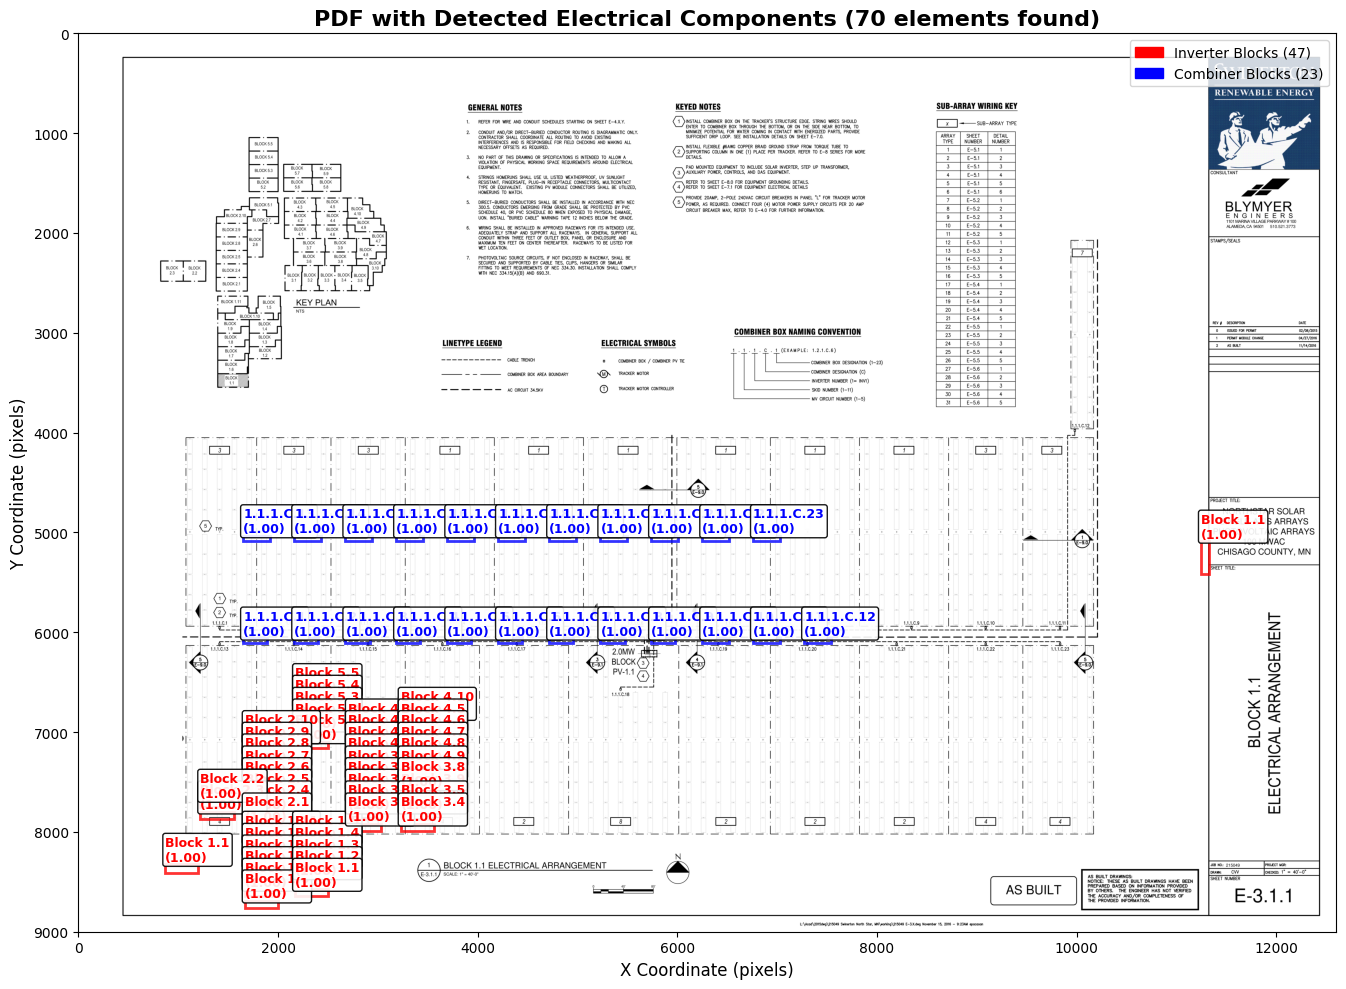

🎉 Pipeline completed successfully!


In [44]:
# Example: Process one of the available PDF files
# Update this path to point to one of your PDF files
pdf_path = "C:/Users/roba7/Documents/Programming projects/as-built-processing/as-built-processing-test/pdf-layout-extraction-test/NorthStar_As_Built/NorthStarAsBuiltRev220161115_page14.pdf"


# Check if file exists
if os.path.exists(pdf_path):
    print(f"📁 Found PDF: {pdf_path}")
    
    # Run the complete pipeline
    results = run_full_pipeline(
        pdf_path=pdf_path,
        page_num=0,  # First page
        dpi=300,     # Good balance of quality and speed
        show_plot=True,
        show_summary=True
    )
    
    if results:
        print("🎉 Pipeline completed successfully!")
        
        # You can access individual results:
        # results['bounding_boxes'] - The extracted bounding box data
        # results['image'] - The PIL image
        # results['page_info'] - Page dimension information
        # results['pdf_path'] - Original PDF path
        # results['page_num'] - Page number processed
        
    else:
        print("❌ Pipeline failed")
        
else:
    print(f"❌ PDF file not found: {pdf_path}")
    print("Available PDF files:")
    pdf_dir = "../../docs/full_pdf/"
    if os.path.exists(pdf_dir):
        for file in os.listdir(pdf_dir):
            if file.endswith('.pdf'):
                print(f"  - {file}")
    else:
        print("  - No PDF directory found")


In [ ]:
# Test with different PDF files
test_pdfs = [
    "2024.06.18_SNJUAN_E_PV_AS-BUILT - Stamped.pdf",
    "2025.07.29_Horn Shadow_SV_Record Drawings.pdf",
    "NorthStar As Built - Rev 2 2016-11-15.pdf",
    "Sigurd Electrical CCR 20210507.pdf"
]

# Choose which PDF to test (uncomment one)
# selected_pdf = test_pdfs[0]  # Solar PV As-Built
# selected_pdf = test_pdfs[1]  # Horn Shadow Record Drawings  
# selected_pdf = test_pdfs[2]  # NorthStar As Built
# selected_pdf = test_pdfs[3]  # Sigurd Electrical

# Uncomment to run:
# pdf_path = f"../../docs/full_pdf/{selected_pdf}"
# results = run_full_pipeline(pdf_path, page_num=0, dpi=150)

# Test with different settings
def test_different_settings(pdf_path: str):
    """Test the same PDF with different DPI settings."""
    print("Testing different DPI settings...")
    
    dpi_settings = [100, 150, 200]
    for dpi in dpi_settings:
        print(f"\n{'='*50}")
        print(f"Testing with DPI: {dpi}")
        print(f"{'='*50}")
        
        results = run_full_pipeline(
            pdf_path=pdf_path,
            page_num=0,
            dpi=dpi,
            show_plot=False,  # Don't show plots for comparison
            show_summary=True
        )

# Uncomment to test different DPI settings:
# test_different_settings(pdf_path)
